In [90]:
from __future__ import division

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from scipy.cluster.vq import kmeans, kmeans2, whiten

from pymongo import *
from mpl_toolkits.basemap import Basemap
from collections import Counter
import ast

from datetime import datetime

% matplotlib inline

In [2]:
def preprocess_raw(df):
    
    # date to datetime
    date_format = '%m/%d/%Y %I:%M:%S %p'
    df['Date'] = df['Date'].apply(lambda x : datetime.strptime(x, date_format))
   
    df['Year']  = df['Date'].apply(lambda x : x.year)
    df['Month'] = df['Date'].apply(lambda x : x.month)
    df['Day of Year'] = df['Date'].apply(lambda x : x.timetuple().tm_yday)
    df['Day of Week'] = df['Date'].apply(lambda x : x.date().weekday())
    df['Hour'] = df['Date'].apply(lambda x : x.hour)
    df['Minute of Day'] = df['Date'].apply(lambda x : 60 * x.hour + x.minute)
    
    df.replace({'X Coordinate' : {0 : np.nan},
                'Y Coordinate' : {0 : np.nan},
                'Location' : {'(36.619446395, -91.686565684)' : np.nan}}, inplace = True)
    
    df['Longitude'][df['X Coordinate'].isnull()] = np.nan
    df['Latitude'][df['X Coordinate'].isnull()] = np.nan
       
    return df

In [3]:
df = pd.read_csv('Crimes_-_2001_to_present.csv')
df = preprocess_raw(df)

df.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Year,Updated On,Latitude,Longitude,Location,Month,Day of Year,Day of Week,Hour,Minute of Day
0,10288746,HY476724,2015-10-24 23:59:00,016XX E HAYES DR,0610,BURGLARY,FORCIBLE ENTRY,PARK PROPERTY,False,False,...,2015,10/31/2015 03:56:20 PM,41.780617,-87.584477,"(41.780617401, -87.584477038)",10,297,5,23,1439
1,10288063,HY475407,2015-10-24 23:55:00,003XX W 51ST ST,051A,ASSAULT,AGGRAVATED: HANDGUN,ALLEY,False,False,...,2015,10/31/2015 03:56:20 PM,41.801803,-87.633699,"(41.801803486, -87.633699142)",10,297,5,23,1435
2,10287811,HY476065,2015-10-24 23:50:00,117XX S MARSHFIELD AVE,0820,THEFT,$500 AND UNDER,GROCERY FOOD STORE,False,False,...,2015,10/31/2015 03:56:20 PM,41.680418,-87.662438,"(41.680418426, -87.662437948)",10,297,5,23,1430
3,10287226,HY475363,2015-10-24 23:50:00,083XX S ELLIS AVE,0460,BATTERY,SIMPLE,SIDEWALK,False,False,...,2015,10/31/2015 03:56:20 PM,41.743574,-87.600158,"(41.743574495, -87.600158418)",10,297,5,23,1430
4,10287210,HY475369,2015-10-24 23:50:00,039XX S CALIFORNIA AVE,0454,BATTERY,AGG PO HANDS NO/MIN INJURY,JAIL / LOCK-UP FACILITY,True,False,...,2015,10/31/2015 03:56:20 PM,41.822562,-87.694647,"(41.822562231, -87.694646782)",10,297,5,23,1430


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5924265 entries, 0 to 5924264
Data columns (total 27 columns):
ID                      int64
Case Number             object
Date                    datetime64[ns]
Block                   object
IUCR                    object
Primary Type            object
Description             object
Location Description    object
Arrest                  bool
Domestic                bool
Beat                    int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                object
X Coordinate            float64
Y Coordinate            float64
Year                    int64
Updated On              object
Latitude                float64
Longitude               float64
Location                object
Month                   int64
Day of Year             int64
Day of Week             int64
Hour                    int64
Minute of Day           int64
dtypes: bool(2), datetime64[ns](1), float64(7),

In [5]:
df.count()

ID                      5924265
Case Number             5924262
Date                    5924265
Block                   5924265
IUCR                    5924265
Primary Type            5924265
Description             5924265
Location Description    5923392
Arrest                  5924265
Domestic                5924265
Beat                    5924265
District                5924216
Ward                    5309385
Community Area          5308133
FBI Code                5924265
X Coordinate            5871646
Y Coordinate            5871646
Year                    5924265
Updated On              5924134
Latitude                5871646
Longitude               5871646
Location                5871646
Month                   5924265
Day of Year             5924265
Day of Week             5924265
Hour                    5924265
Minute of Day           5924265
dtype: int64

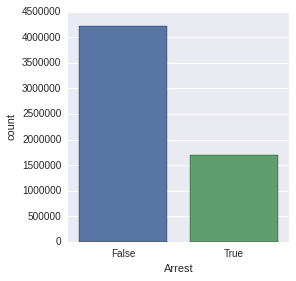

In [6]:
sns.factorplot(x = 'Arrest', data = df, kind = "count")

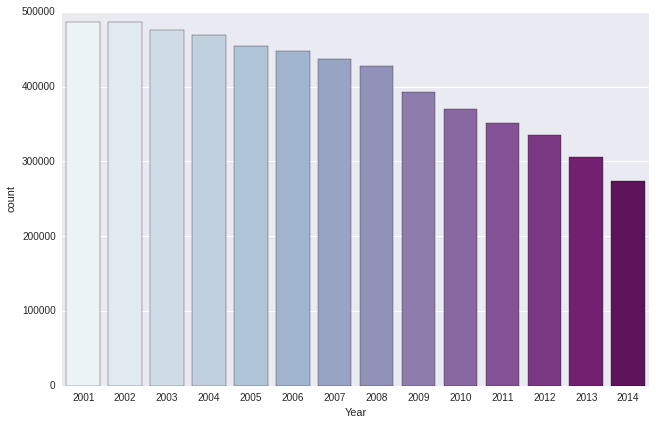

In [7]:
years = np.arange(2001, 2015)
g = sns.factorplot(x = "Year", data = df, kind = "count",
                   palette = "BuPu", size = 6, aspect = 1.5, order = years)

In [8]:
by_description = df[['Location Description', 'ID']].groupby('Location Description').agg('count').sort('ID', ascending = False)

In [9]:
by_description.drop('OTHER')[:10][:10].index

Index([u'STREET', u'RESIDENCE', u'SIDEWALK', u'APARTMENT',
       u'PARKING LOT/GARAGE(NON.RESID.)', u'ALLEY',
       u'SCHOOL, PUBLIC, BUILDING', u'RESIDENCE-GARAGE',
       u'RESIDENCE PORCH/HALLWAY', u'SMALL RETAIL STORE'],
      dtype='object', name=u'Location Description')

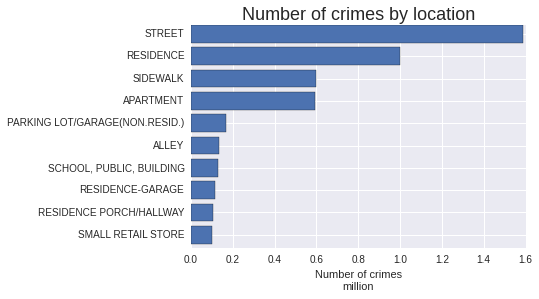

In [10]:
width = .4
ind = np.arange(10)
plt.barh(ind, list(by_description.drop('OTHER')[:10]['ID'] / 10**6))
plt.yticks(ind + width, by_description.drop('OTHER')[:10].index) # rotation = 45)
plt.title('Number of crimes by location', fontsize = 18)
plt.xlabel('Number of crimes\nmillion')
plt.gca().invert_yaxis()
plt.show()

# Homicide

In [11]:
by_type = df[['Primary Type', 'ID']].groupby('Primary Type').agg('count').sort('ID', ascending = False)

In [28]:
by_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35 entries, THEFT to DOMESTIC VIOLENCE
Data columns (total 1 columns):
ID    35 non-null int64
dtypes: int64(1)
memory usage: 560.0+ bytes


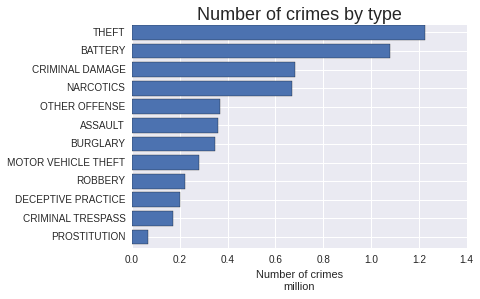

In [21]:
width = .4
ind = np.arange(len(by_type[:12]))
plt.barh(ind, list(by_type['ID'][:12] / 10**6))
plt.yticks(ind + width, by_type[:12].index)
plt.title('Number of crimes by type', fontsize = 18)
plt.xlabel('Number of crimes\nmillion')
plt.gca().invert_yaxis()
plt.show()

In [23]:
homicide = df[df['Primary Type'] == 'HOMICIDE']
homicide.dropna(subset = ['Latitude'], inplace = True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
hom_lon = list(homicide['Longitude'])
hom_lat = list(homicide['Latitude'])
print 'all longitude between', df['Longitude'].min(), 'and',  df['Longitude'].max()
print 'homicide longitude between', min(hom_lon), 'and', max(hom_lon), '\n'
print 'all latitude between', df['Latitude'].min(), 'and',  df['Latitude'].max()
print 'homicide latitude between', min(hom_lat), 'and', max(hom_lat)

all longitude between -87.934324986 and -87.524388789
homicide longitude between -87.846467101 and -87.525758806 

all latitude between 41.644580105 and 42.023024908
homicide latitude between 41.648611226 and 42.022547568


# Map visualization

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-9784983.24073,5101248.43817,-9729323.49533,5168472.1466&bboxSR=3857&imageSR=3857&size=1000,1207&dpi=96&format=png32&f=image


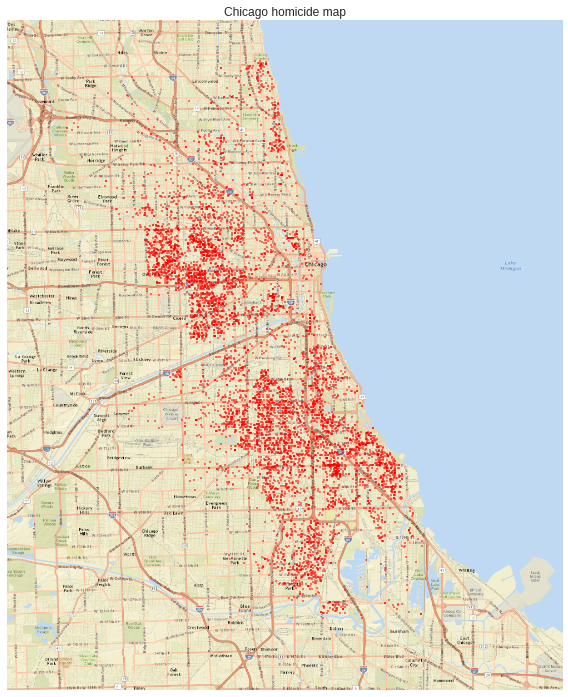

In [25]:
plt.figure(figsize = (10, 12))
m = Basemap(epsg = 3857,
            llcrnrlon = -87.9,
            llcrnrlat = 41.6,
            urcrnrlon = -87.4,
            urcrnrlat = 42.05,
            projection = 'merc',
            resolution = 'l')
m.arcgisimage(service = 'World_Street_Map', xpixels = 1000, verbose= True)
m.scatter(hom_lon[:], hom_lat[:], s = 2, marker = 'o', color = 'r', latlon = True, alpha = 0.8)
plt.title('Chicago homicide map')
plt.show()

# Clustering of homicides with DBSCAN

In [118]:
coord = homicide.as_matrix(columns=['Longitude', 'Latitude'])

In [30]:
coord

array([[-87.64280582,  41.79736346],
       [-87.77820304,  41.97448687],
       [-87.72335863,  41.84538596],
       ..., 
       [-87.62078848,  41.81113151],
       [-87.69993323,  41.92448827],
       [-87.68824895,  41.88022455]])

In [84]:
db = DBSCAN(eps = .003, min_samples = 1).fit(coord)
labels = db.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([coord[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 544


In [85]:
def getCentroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

def getNearestPoint(set_of_points, point_of_reference):
    closest_point = None
    closest_dist = None
    for point in set_of_points:
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    return closest_point

In [86]:
hom_lon_reduced = []
hom_lat_reduced = []
for i, cluster in clusters.iteritems():
    if len(cluster) < 3:
        representative_point = (cluster[0][1], cluster[0][0])
    else:
        representative_point = getNearestPoint(cluster, getCentroid(cluster))
    hom_lon_reduced.append(representative_point[1])
    hom_lat_reduced.append(representative_point[0])

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-9784983.24073,5101248.43817,-9729323.49533,5168472.1466&bboxSR=3857&imageSR=3857&size=1000,1207&dpi=96&format=png32&f=image


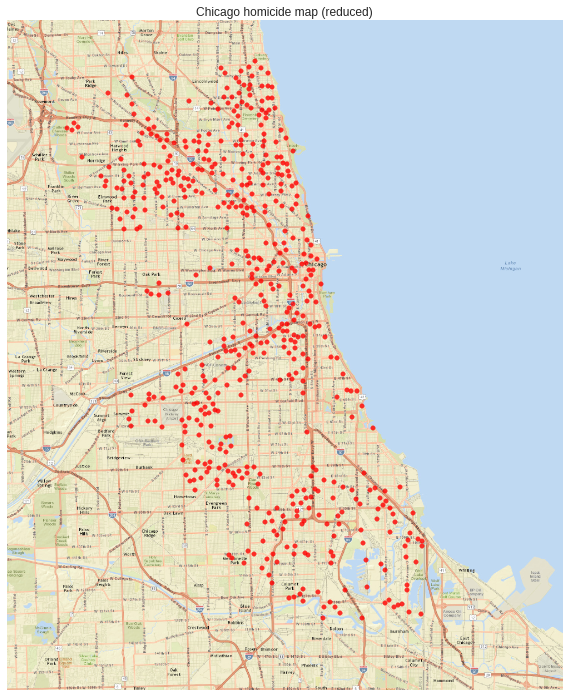

In [88]:
plt.figure(figsize = (10, 12))
m = Basemap(epsg = 3857,
            llcrnrlon = -87.9,
            llcrnrlat = 41.6,
            urcrnrlon = -87.4,
            urcrnrlat = 42.05,
            projection = 'merc',
            resolution = 'l')
m.arcgisimage(service = 'World_Street_Map', xpixels = 1000, verbose = True)
m.scatter(hom_lon_reduced[:], hom_lat_reduced[:], s = 20, marker = 'o', color = 'r', latlon = True, alpha = 0.8)
plt.title('Chicago homicide map (reduced)')
plt.show()

# Clustering of homicides with KMeans

In [132]:
N = len(coord)
k = 500
i = 50
w = whiten(coord)

In [133]:
cluster_centroids, closest_centroids = kmeans2(w, k, iter = i, minit = 'points')

In [134]:
print 'k =', k
print 'N =', N
print 'Number of centroids', len(cluster_centroids)
print 'Number of unique centroids', len(np.unique(closest_centroids))
print len(closest_centroids)

k = 500
N = 7345
Number of centroids 500
Number of unique centroids 500
7345


In [135]:
coord_reduced = pd.DataFrame(data = coord, columns = ['Longitude', 'Latitude'])
coord_reduced['Cluster'] = closest_centroids
coord_reduced.drop_duplicates(subset = ['Cluster'], take_last = False, inplace = True)

In [136]:
hom_lon_reduced = list(coord_reduced['Longitude'])
hom_lat_reduced = list(coord_reduced['Latitude'])

http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-9784983.24073,5101248.43817,-9729323.49533,5168472.1466&bboxSR=3857&imageSR=3857&size=1000,1207&dpi=96&format=png32&f=image


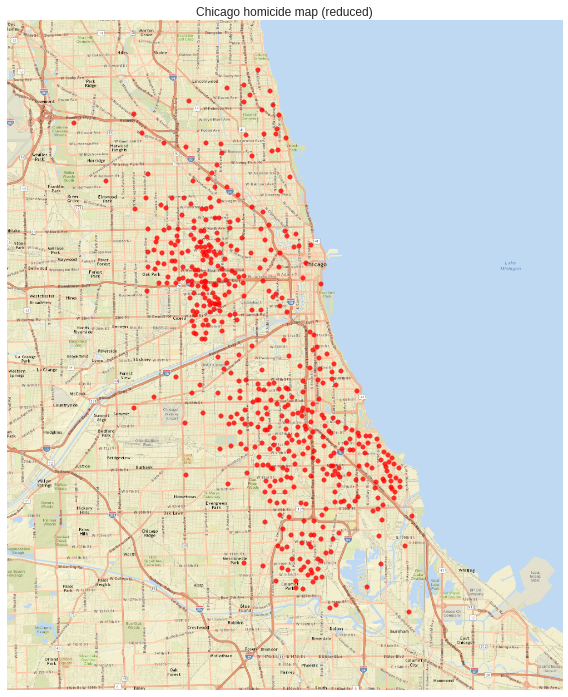

In [137]:
plt.figure(figsize = (10, 12))
m = Basemap(epsg = 3857,
            llcrnrlon = -87.9,
            llcrnrlat = 41.6,
            urcrnrlon = -87.4,
            urcrnrlat = 42.05,
            projection = 'merc',
            resolution = 'l')
m.arcgisimage(service = 'World_Street_Map', xpixels = 1000, verbose = True)
m.scatter(hom_lon_reduced[:], hom_lat_reduced[:], s = 20, marker = 'o', color = 'r', latlon = True, alpha = 0.8)
plt.title('Chicago homicide map (reduced)')
plt.show()